In [5]:
import io
import openpyxl
import seaborn as sns
import numpy as np
from numpy import mean, std
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.datasets import make_multilabel_classification
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV, KFold, train_test_split, RepeatedKFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from xgboost.sklearn import plot_importance
from xgboost import XGBRegressor, plot_importance

# pip install category_encoders

import category_encoders as ce
# pip install shap

import shap

In [6]:
data_train = pd.read_csv("Train.csv", sep=",")
data_test = pd.read_csv("Test.csv", sep=",")
data = pd.concat([data_train, data_test])
#data


In [7]:
data.shape

(10695, 11)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB


In [9]:
data.isnull().sum() #check for nulls in dataset

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

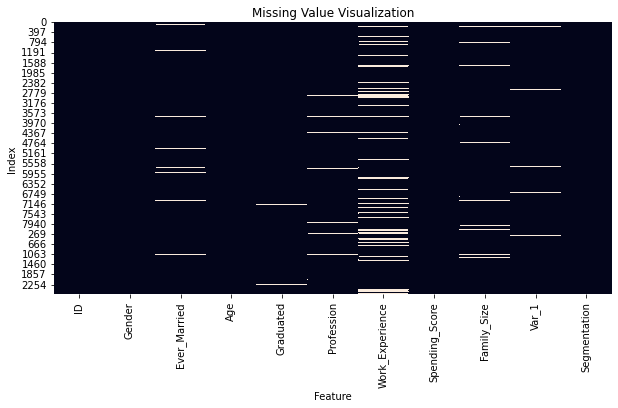

In [10]:
plt.subplots(figsize=(10,5))
sns.heatmap(data.isnull(),cbar=False)
plt.xlabel('Feature')
plt.ylabel('Index')
plt.title('Missing Value Visualization')

plt.show()

In [11]:
data_balancing = pd.DataFrame()
data_balancing["Count"] = data["Segmentation"].value_counts()
data_balancing["Count%"] = data["Segmentation"].value_counts()/data.shape[0]*100

data_balancing

,Count,Count%
D,3027,28.302945
A,2818,26.348761
C,2442,22.833100
B,2408,22.515194


(array([], dtype=float64), <a list of 0 Text major ticklabel objects>)

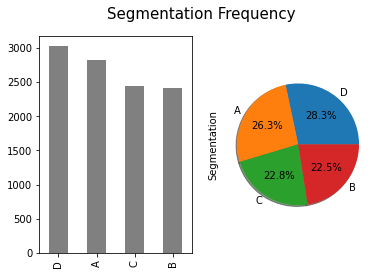

In [12]:
fig, ax = plt.subplots(1, 2)
data["Segmentation"].value_counts().plot.bar(color="gray", ax=ax[0])
data["Segmentation"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Segmentation Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

In [13]:
# Based On Gender
gender_based = pd.pivot_table(data,values='ID',index=['Gender'],columns=['Segmentation'],aggfunc=np.count_nonzero)

In [14]:
gender_based

Segmentation,A,B,C,D
Gender,,,,
Female,1302,1098,1145,1309
Male,1516,1310,1297,1718


In [15]:
data = data.drop('ID', axis =1 )

In [16]:
#Filling nans with the mean 
mean_value_1 = data['Family_Size'].mean()
data['Family_Size'].fillna(value = mean_value_1,  inplace=True)


In [17]:
#Filling nans with the mean 
mean_value_2 = data['Work_Experience'].mean()
data['Work_Experience'].fillna(value = mean_value_2,  inplace=True)


In [18]:
#Dropping all nans as they are not numeric and cant be replaced by nans or 0s
data.dropna(axis=0,inplace=True)
data.isnull().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [19]:
#Gettting binary form of some columns

data["Ever_Married"] = label_binarize(data["Ever_Married"], classes = ["Yes", "No"])
data["Graduated"] = label_binarize(data["Graduated"], classes = ["Yes", "No"])
data["Gender"] = label_binarize(data["Gender"], classes = ["Male", "Female"])


In [20]:
data

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,1,22,1,Healthcare,1.000000,Low,4.0,Cat_4,D
1,1,0,38,0,Engineer,2.619777,Average,3.0,Cat_4,A
2,1,0,67,0,Engineer,1.000000,Low,1.0,Cat_6,B
3,0,0,67,0,Lawyer,0.000000,High,2.0,Cat_6,B
4,1,0,40,0,Entertainment,2.619777,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...
2622,0,1,29,1,Healthcare,9.000000,Low,4.0,Cat_6,B
2623,1,1,35,0,Doctor,1.000000,Low,1.0,Cat_6,A
2624,1,1,53,0,Entertainment,2.619777,Low,2.0,Cat_6,C
2625,0,0,47,0,Executive,1.000000,High,5.0,Cat_4,C


In [21]:
X = data.drop('Segmentation', axis= 1)
y = data.Segmentation

In [22]:
encoder = ce.OneHotEncoder(cols=['Spending_Score', 'Profession', 'Var_1'])
encoder.fit(X, y)
X_cleaned = encoder.transform(X)

In [23]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size= 0.33, random_state=0)

## Feature Importancde including Permutation Importance and SHAP

In [25]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [26]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train.columns[index], model.feature_importances_[index]]) 

['Spending_Score_1', 0.21692953]
['Profession_5', 0.10265682]
['Age', 0.09128228]
['Graduated', 0.07122505]
['Profession_1', 0.06546731]
['Profession_9', 0.052575573]
['Spending_Score_2', 0.044738766]
['Profession_4', 0.03525574]
['Var_1_1', 0.030428218]
['Ever_Married', 0.030411763]
['Profession_2', 0.026029663]
['Var_1_2', 0.021766126]
['Profession_7', 0.021691551]
['Var_1_5', 0.021510277]
['Family_Size', 0.021445336]
['Gender', 0.019241342]
['Var_1_7', 0.017203564]
['Spending_Score_3', 0.01658984]
['Work_Experience', 0.016531507]
['Profession_6', 0.01575708]
['Var_1_3', 0.0140555985]
['Profession_8', 0.01382838]
['Var_1_6', 0.013088797]
['Var_1_4', 0.010474011]
['Profession_3', 0.0098159155]


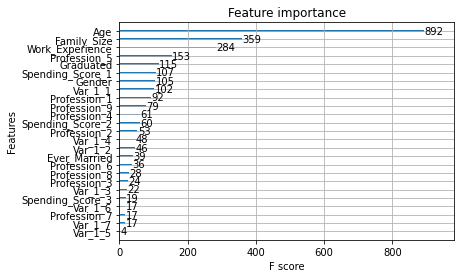

In [27]:
plot_importance(model, max_num_features = 25,  )

plt.show()

Permutation Feature Importance 


In [28]:
model_1 = XGBClassifier(n_estimators = 100)
model_1.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [29]:
perm_importance = permutation_importance(model_1, X_test, y_test)

In [30]:
sorted_idx = perm_importance.importances_mean.argsort()
for index in sorted_idx:
    print([X_train.columns[index], perm_importance.importances_mean[index]]) 

['Var_1_1', -0.0010143198090692197]
['Var_1_6', -0.0004773269689737347]
['Var_1_5', 0.0]
['Profession_8', 0.0]
['Var_1_3', 0.0002983293556085842]
['Spending_Score_3', 0.0002983293556085842]
['Var_1_7', 0.00035799522673030104]
['Ever_Married', 0.0006563245823389075]
['Profession_3', 0.0007159904534606131]
['Gender', 0.0008949880668257748]
['Profession_7', 0.001252983293556087]
['Var_1_4', 0.0013126491646778039]
['Profession_6', 0.001312649164677815]
['Var_1_2', 0.0017899761336515497]
['Profession_2', 0.0031622911694510814]
['Work_Experience', 0.00417661097852029]
['Profession_4', 0.004236276849642007]
['Profession_9', 0.004295942720763735]
['Profession_1', 0.007756563245823389]
['Spending_Score_2', 0.00835322195704058]
['Family_Size', 0.00871121718377088]
['Graduated', 0.012768496420047737]
['Profession_5', 0.026789976133651538]
['Spending_Score_1', 0.03741050119331742]
['Age', 0.07219570405727924]


Text(0.5, 1.0, 'Permutation Importance')

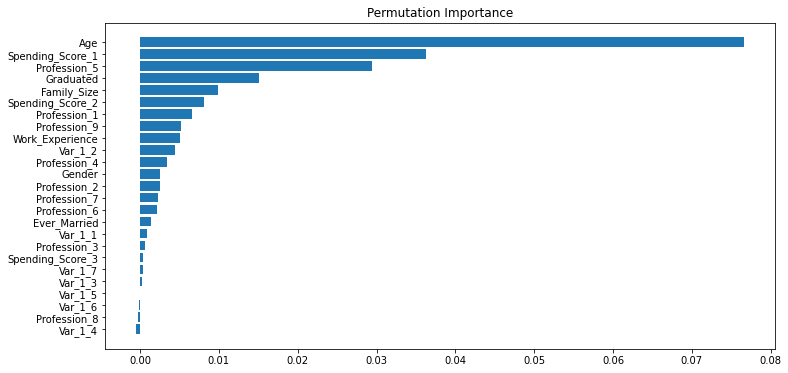

In [31]:
perm_importance = permutation_importance(model_1, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

Shap


In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

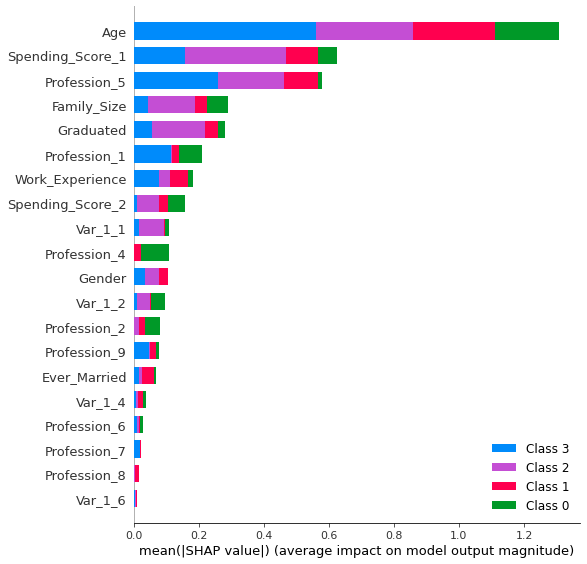

In [33]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [34]:
features_imp = ['Age', 'Spending_Score_1', 'Profession_5', 'Graduated', 'Profession_1', 'Family_Size', 'Spending_Score_2', 'Work_Experience', 'Profession_4', 'Var_1_1', 'Var_1_2', 'Profession_9', 'Profession_2', 'Gender', 'Ever_Married', 'Profession_6']

In [35]:
features_imp

['Age',
 'Spending_Score_1',
 'Profession_5',
 'Graduated',
 'Profession_1',
 'Family_Size',
 'Spending_Score_2',
 'Work_Experience',
 'Profession_4',
 'Var_1_1',
 'Var_1_2',
 'Profession_9',
 'Profession_2',
 'Gender',
 'Ever_Married',
 'Profession_6']

In [36]:
train_imp = X_train[features_imp]
test_imp = X_test[features_imp]

In [37]:
# Saving train dataset 
train_imp.to_csv('TrainImportantVars.csv', index=False)

In [38]:
#Saving train dataset 
test_imp.to_csv('TestImportantVars.csv', index=False)

In [39]:
y_train.shape

(6805,)

In [40]:
X_train = train_imp
X_test = test_imp

### Parameter Tunning

In [41]:
results_xgb = {'learning_rate':[], 'max_depth':[], 'n_estimates':[], 'score_train':[], 'score_test': []}

In [42]:
results = []
for i in np.arange(0.1, 0.9, 0.2):
    for j in range(1, 10, 2):
        for k in range (500, 2000, 500):
            print('learning rate: ', i, " max_depth: ", j, "n_estimates: ", k)
            model = XGBClassifier(learning_rate=i, max_depth=j, n_estimators=k, random_state=0)
            model.fit(X_train, y_train, eval_metric='auc', verbose=30)
            results_xgb['learning_rate'].append(i)
            results_xgb['max_depth'].append(j)
            results_xgb['n_estimates'].append(k)


            Y_xgb_train = model.predict_proba(X_train)[:,1]
            Y_xgb_test = model.predict_proba(X_test)[:,1]

            results_xgb['score_train'].append(roc_auc_score(y_train, Y_xgb_train))
            results_xgb['score_test'].append(roc_auc_score(y_test, Y_xgb_test)) 

learning rate:  0.1  max_depth:  1 n_estimates:  500


ValueError: ignored

In [43]:
results_xgb = pd.DataFrame.from_dict(results_xgb)
results_xgb[results_xgb['score_test'] == max(results_xgb['score_test'])]

ValueError: ignored

In [44]:
data_train = pd.read_csv("Train.csv", sep=",")
data_test = pd.read_csv("Test.csv", sep=",")
data = pd.concat([data_train, data_test])

In [45]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [46]:
#Gettting binary form of some columns

data["Ever_Married"] = label_binarize(data["Ever_Married"], classes = ["Yes", "No"])
data["Graduated"] = label_binarize(data["Graduated"], classes = ["Yes", "No"])
data["Gender"] = label_binarize(data["Gender"], classes = ["Male", "Female"])

In [47]:
X = data.drop('Segmentation', axis= 1)
y = data.Segmentation

In [48]:
encoder = ce.OneHotEncoder(cols=['Spending_Score', 'Profession', 'Var_1'])
encoder.fit(X, y)
X_cleaned = encoder.transform(X)

In [49]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size= 0.33, random_state=0)

In [51]:
xgb_cl = XGBClassifier(
    learning_rate = 0.1,
    max_depth = 5,
    n_estimators= 1000,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8)

#Fit
xgb_cl.fit(X_cleaned, y)

#Predict
preds = xgb_cl.predict(X_test)

#Score 
accuracy_score(y_test, preds)

0.8976296805221573

In [52]:
data_train = pd.read_csv("Train.csv", sep=",")
data_test = pd.read_csv("Test.csv", sep=",")
data_ = pd.concat([data_train, data_test])

In [53]:
#Filling nans with the mean 
mean_value_1 = data_['Family_Size'].mean()
data_['Family_Size'].fillna(value = mean_value_1,  inplace=True)

#Filling nans with the mean 
mean_value_2 = data_['Work_Experience'].mean()
data_['Work_Experience'].fillna(value = mean_value_2,  inplace=True)

#Dropping all nans as they are not numeric and cant be replaced by nans or 0s
data_.dropna(axis=0,inplace=True)
data_.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [54]:
data_["Ever_Married"] = label_binarize(data_["Ever_Married"], classes = ["Yes", "No"])
data_["Graduated"] = label_binarize(data_["Graduated"], classes = ["Yes", "No"])
data_["Gender"] = label_binarize(data_["Gender"], classes = ["Male", "Female"])


In [55]:
X = data_.drop('Segmentation', axis= 1)
y = data_.Segmentation

In [56]:
encoder = ce.OneHotEncoder(cols=['Spending_Score', 'Profession', 'Var_1'])
encoder.fit(X, y)
X_cleaned = encoder.transform(X)


In [57]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size= 0.33, random_state=0)

In [59]:
xgb_cl = XGBClassifier(
    learning_rate = 0.1,
    max_depth = 5,
    n_estimators= 1000,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8)

#Fit
xgb_cl.fit(X_cleaned, y)

#Predict
preds = xgb_cl.predict(X_test)

#Score 
accuracy_score(y_test, preds)

0.877983293556086

When i modify the Nan values, in some columns i put the
mean and for others just deleted the nans, the accuracy of XGBClassifier gives me 0.877 accuracy meanwhile when i drop all NANs it gives 0,897 accuracy. And also while tried to check for only importance features it gives lower accuracy score. 

## Keras

In [60]:
pip install keras

In [61]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


In [62]:
data_train = pd.read_csv("Train.csv", sep=",")
data_test = pd.read_csv("Test.csv", sep=",")

data = pd.concat([data_train, data_test])

In [63]:
mean_value_1 = data['Family_Size'].mean()
data['Family_Size'].fillna(value = mean_value_1,  inplace=True)

mean_value_2 = data['Work_Experience'].mean()
data['Work_Experience'].fillna(value = mean_value_2,  inplace=True)

data.dropna(axis=0,inplace=True)
data.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
dtype: int64

In [64]:
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.000000,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,2.619777,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.000000,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.000000,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,2.619777,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.000000,Low,4.0,Cat_6,B
2623,467958,Female,No,35,Yes,Doctor,1.000000,Low,1.0,Cat_6,A
2624,467960,Female,No,53,Yes,Entertainment,2.619777,Low,2.0,Cat_6,C
2625,467961,Male,Yes,47,Yes,Executive,1.000000,High,5.0,Cat_4,C


In [65]:
from sklearn.preprocessing import label_binarize
data["Ever_Married"] = label_binarize(data["Ever_Married"], classes = ["Yes", "No"])
data["Profession"] = label_binarize(data["Profession"], classes = ["Healthcare", "Engineer", "Lawyer", "Artist", "Doctor", "Homemaker", "Entertainment", "Marketing", "Executive"])
data["Graduated"] = label_binarize(data["Graduated"], classes = ["Yes", "No"])
data["Spending_Score"] = label_binarize(data["Graduated"], classes = ["Low", "High", "Average"])
data["Var_1"] = label_binarize(data["Var_1"], classes = ["Cat_1","Cat_2","Cat_3","Cat_4","Cat_5","Cat_6","Cat_7"])
data["Gender"] = label_binarize(data["Gender"], classes = ["Male", "Female"])
data["Segmentation"] = label_binarize(data["Segmentation"], classes = ["A", "B", "C" "D"])


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10157 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10157 non-null  int64  
 1   Gender           10157 non-null  int64  
 2   Ever_Married     10157 non-null  int64  
 3   Age              10157 non-null  int64  
 4   Graduated        10157 non-null  int64  
 5   Profession       10157 non-null  int64  
 6   Work_Experience  10157 non-null  float64
 7   Spending_Score   10157 non-null  int64  
 8   Family_Size      10157 non-null  float64
 9   Var_1            10157 non-null  int64  
 10  Segmentation     10157 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 952.2 KB


In [67]:
dataset = data.values

X = dataset[:,0:10].astype(float)
y = dataset[:,10:11]

In [68]:
X.shape

(10157, 10)

In [69]:
y.shape

(10157, 1)

In [70]:
# summarize dataset shape
print(X.shape, y.shape)
# summarize first few examples
for i in range(10):
    print(X[i], y[i])


(10157, 10) (10157, 1)
[4.62809e+05 0.00000e+00 1.00000e+00 2.20000e+01 1.00000e+00 1.00000e+00
 1.00000e+00 0.00000e+00 4.00000e+00 0.00000e+00] [0.]
[4.62643000e+05 1.00000000e+00 0.00000000e+00 3.80000000e+01
 0.00000000e+00 0.00000000e+00 2.61977701e+00 0.00000000e+00
 3.00000000e+00 0.00000000e+00] [1.]
[4.66315e+05 1.00000e+00 0.00000e+00 6.70000e+01 0.00000e+00 0.00000e+00
 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00] [0.]
[4.61735e+05 0.00000e+00 0.00000e+00 6.70000e+01 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 2.00000e+00 0.00000e+00] [0.]
[4.62669000e+05 1.00000000e+00 0.00000000e+00 4.00000000e+01
 0.00000000e+00 0.00000000e+00 2.61977701e+00 0.00000000e+00
 6.00000000e+00 0.00000000e+00] [1.]
[4.61319e+05 0.00000e+00 0.00000e+00 5.60000e+01 1.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 2.00000e+00 0.00000e+00] [0.]
[4.60156e+05 0.00000e+00 1.00000e+00 3.20000e+01 0.00000e+00 1.00000e+00
 1.00000e+00 0.00000e+00 3.00000e+00 0.00000e+00] [0.]
[4.64347e+05 1.0000

In [71]:
# define the model
model = Sequential()
model.add(Dense(20, input_dim = 11, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [72]:
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [73]:
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        # calculate accuracy
        acc = accuracy_score(y_test, yhat)
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

In [74]:
results = evaluate_model(X, y)

>0.741
>0.747
>0.257
>0.740
>0.727
>0.731
>0.748
>0.727
>0.259
>0.266
>0.735
>0.741
>0.751
>0.741
>0.752
>0.727
>0.280
>0.729
>0.335
>0.248
>0.743
>0.269
>0.739
>0.751
>0.739
>0.720
>0.744
>0.737
>0.262
>0.737


In [75]:
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

Accuracy: 0.614 (0.207)


In [76]:
dataset = data.values
# split into input (X) and output (Y) variables
X = dataset[:,0:10].astype(float)
y = dataset[:,10:11]


In [77]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
history = model.fit(X, y, epochs=100, batch_size=10, validation_split=0.33)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100
681/681 [==============================] - 5s 5ms/step - loss: 1260.9255 - accuracy: 0.6193 - val_loss: 166.3941 - val_accuracy: 0.7035
Epoch 2/100
681/681 [==============================] - 3s 4ms/step - loss: 66.2150 - accuracy: 0.6267 - val_loss: 118.9335 - val_accuracy: 0.7035
Epoch 3/100
681/681 [==============================] - 2s 4ms/step - loss: 67.4584 - accuracy: 0.6251 - val_loss: 46.3643 - val_accuracy: 0.7035
Epoch 4/100
681/681 [==============================] - 3s 4ms/step - loss: 71.7636 - accuracy: 0.6316 - val_loss: 125.6756 - val_accuracy: 0.2965
Epoch 5/100
681/681 [==============================] - 4s 5ms/step - loss: 75.1895 - accuracy: 0.6231 - val_loss: 5.2356 - val_accuracy: 0.7035
Epoch 6/100
681/681 [==============================] - 2s 3ms/step - loss: 69.9673 - accuracy: 0.6291 - val_loss: 204.3438 - val_accuracy: 0.7035
Epoch 7/100
681/681 [==============================] - 1s 2ms/step - loss: 53.1664 - accuracy: 0.6338 - val_loss: 53.3673 - v

In [78]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


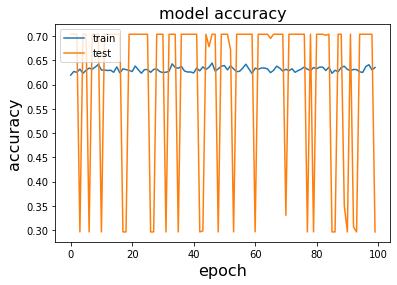

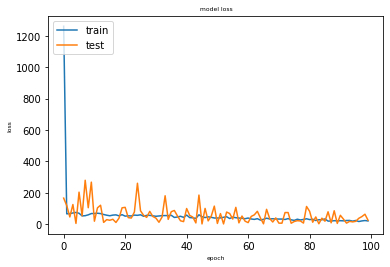

In [79]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=6)
plt.ylabel('loss', fontsize=6)
plt.xlabel('epoch', fontsize=6)
plt.legend(['train', 'test'], loc='upper left')
plt.show()